# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

a = 'Hello world'
print(a)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]
[asl.df.ix[99,:][v] for v in features_ground]

[frame
 0     10
 1     10
 2     10
 3     10
 4     10
 5     10
 6     10
 7     10
 8     10
 9      7
 10     8
 11     8
 12     8
 13    -1
 14    -8
 15    -7
 16    -8
 17    -8
 18    -8
 19   -11
 20   -11
 21   -11
 22   -11
 23   -11
 24   -11
 25   -13
 26   -13
 27   -21
 28   -23
 29   -31
       ..
 45   -36
 46   -30
 47   -23
 48   -18
 49   -18
 50   -18
 51   -18
 52    -9
 53    -9
 54    -9
 55   -11
 56    -5
 57    -5
 58    -4
 59    -4
 60    -4
 61    -4
 62    -4
 63    -4
 64    -8
 65    -8
 66    -8
 67    -6
 68    -7
 69    -7
 70    -2
 71     0
 72     0
 73     4
 74     4
 Name: grnd-rx, dtype: int64, frame
 0     117
 1     117
 2     117
 3     117
 4     117
 5     117
 6     117
 7     117
 8     117
 9     106
 10     96
 11     90
 12     70
 13     60
 14     52
 15     44
 16     38
 17     38
 18     38
 19     31
 20     31
 21     31
 22     31
 23     31
 24     31
 25     27
 26     27
 27     26
 28     27
 29     24
      ... 
 45   

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['PEOPLE', 'TOY1', 'MOVIE', 'HERE', 'HIT', 'NEXT-WEEK', 'ARRIVE', 'LIVE', 'SHOOT', 'CAR', 'WRITE', 'BILL', 'BOX', 'GO', 'READ', 'BOY', 'BUY1', 'LAST-WEEK', 'WHAT', 'YESTERDAY', 'CORN', 'JOHN', 'BLUE', 'LIKE', 'COAT', 'GET', 'POTATO', 'LEAVE', 'MAN', 'CAN', 'GIRL', 'LEG', 'CHINA', 'PAST', 'APPLE', 'MOTHER', 'CANDY', 'BLAME', 'IX', 'SEE', 'FRIEND', 'CHOCOLATE', 'PARTY', 'TOY', 'FUTURE1', 'WANT', 'SAY', 'MANY', 'BUY', 'SUE', 'IX-1P', 'THINK', 'STOLEN', 'THROW', 'POSS', 'GIVE', 'BREAK-DOWN', 'OLD', 'FINISH', 'BUT', 'JANA', 'GROUP', 'HOMEWORK', 'NEW-YORK', 'BORROW', 'GIVE1', 'WILL', 'WONT', 'WOMAN', 'GO1', 'MARY', 'VISIT', 'FUTURE', 'VIDEOTAPE', 'FRANK', 'FISH', 'ALL', 'SELL', 'SHOULD', 'CHICKEN', 'DECIDE', 'NOT', 'PREFER', 'FIND', 'BOOK', 'GIVE2', 'SELF', 'FRED', 'HAVE', 'BROCCOLI', 'WHO', 'CORN1', 'NAME', 'VEGETABLE', 'HOUSE', 'NEW', 'GIVE3', 'STUDENT', 'BROTHER', 'LOVE', 'SOMETHING-ONE', 'EAT', 'KNOW', 'SEARCH-FOR', 'TELL', 'ANN', 'TEACHER', 'CHICAGO', 'TOMORROW', 'SAY-1P

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker

df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
                                                       
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean'])/asl.df['left-y-std']
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean'])/asl.df['right-y-std']



features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])


features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df.groupby(level=0)['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df.groupby(level=0)['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df.groupby(level=0)['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df.groupby(level=0)['left-y'].diff().fillna(0)



features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()



asl.df['polar-rr-mean']= asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rtheta-mean']= asl.df['speaker'].map(df_means['polar-rtheta'])
asl.df['polar-lr-mean']= asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-ltheta-mean']= asl.df['speaker'].map(df_means['polar-ltheta'])
                                                       
asl.df['polar-rr-std']= asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-rtheta-std']= asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['polar-lr-std']= asl.df['speaker'].map(df_std['polar-lr'])
asl.df['polar-ltheta-std']= asl.df['speaker'].map(df_std['polar-ltheta'])

asl.df['norm-rr'] = (asl.df['polar-rr'] - asl.df['polar-rr-mean'])/asl.df['polar-rr-std']
asl.df['norm-rtheta'] = (asl.df['polar-rtheta'] - asl.df['polar-rtheta-mean'])/asl.df['polar-rtheta-std']
asl.df['norm-lr'] = (asl.df['polar-lr'] - asl.df['polar-lr-mean'])/asl.df['polar-lr-std']
asl.df['norm-ltheta'] = (asl.df['polar-ltheta'] - asl.df['polar-ltheta-mean'])/asl.df['polar-ltheta-std']


# TODO define a list named 'features_custom' for building the training set
                                                     
features_custom = ['norm-rr', 'norm-rtheta', 'norm-lr','norm-ltheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I added normalized polar coordinate as an additional feature. I normalized the polar coordinates to account for speakerwise differences that can account for these values such as differences in arm-length, height etc.


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    print(X,lengths)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

[[-11  57   9  58]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57  14  59]
 [-11  53  12  53]
 [ -7  55   6  53]
 [ -7  55   6  53]
 [ -7  55   6  53]
 [ -7  55  13  58]
 [-12  59  20  62]
 [-11  39   3  39]
 [ -4  42   3  39]
 [ -8  40   3  39]
 [-11  41   5  38]
 [-14  42   7  39]
 [-14  42  11  40]
 [-14  42  15  42]
 [ 16  37  33  53]
 [ 20  41  29  48]
 [ 20  41  27  41]
 [ 14  42  25  42]
 [  8  46  22  45]
 [  3  45  25  46]
 [  0  46  25  46]
 [-19  84  11 106]
 [-19  88  11 106]
 [-19  88  11 104]
 [-19  88  11 104]
 [-19  88  11 104]
 [-18  84  12 100]
 [-18  84  12 100]
 [-18  94  14 101]
 [-24 102  16 109]
 [-25 112  14 117]
 [-27 119  19 125]
 [  1  51  18  62]
 [  8  54  15  54]
 [  6  53  15  54]
 [  3  49  17  49]
 [  3  49  17  49]
 [ -4  49  22  50]
 [ -9  55  18  56]
 [ -5  60  23  61]
 [-22  85  25  83]
 [-19  90  30  93]
 [-17  98  19  98]
 [-17  98  24 100]
 [-17 103  21 105]
 [-18 111  20 112]
 [-15 120  20 120]
 [-17 131  1

The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    print("transmat = ", model.transmat_)
    print("startprob_ = ", model.transmat_)
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        
        print("params = ", model.transmat_)
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
transmat =  [[  1.00000000e+00   2.18379429e-14   6.33670569e-50]
 [  4.30307115e-02   9.56969288e-01   1.15300751e-38]
 [  5.23491174e-32   2.26184586e-02   9.77381541e-01]]
startprob_ =  [[  1.00000000e+00   2.18379429e-14   6.33670569e-50]
 [  4.30307115e-02   9.56969288e-01   1.15300751e-38]
 [  5.23491174e-32   2.26184586e-02   9.77381541e-01]]
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
params =  [[  1.00000000e+00   2.18379429e-14   6.33670569e-50]
 [  4.30307115e-02   9.56969288e-01   1.15300751e-38]
 [  5.23491174e-32   2.26184586e-02   9.77381541e-01]]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
params =  [[  1.00000000e+00   2.18379429e-14   6.33670569e-50]
 [  4.30307115e-02   9.56969288e-01   1.15300751e-38]
 [  5.23491174e-32   2.26184586e-02   9.77381541e-01]]
variance =  [ 19.704345

##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

[[-11  48   7 120]
 [-11  48   8 109]
 [ -8  49  11  98]
 [ -7  50   7  87]
 [ -4  54   7  77]
 [ -4  54   6  69]
 [ -4  54   6  69]
 [-13  52   6  69]
 [-13  52   6  69]
 [ -8  51   6  69]
 [ -8  51   6  69]
 [ -8  51   6  69]
 [ -8  51   6  69]
 [ -8  51   6  69]
 [-10  59   7  71]
 [-15  64   9  77]
 [-17  75  13  81]
 [ -4  48  -4 113]
 [ -2  53  -4 113]
 [ -4  55   2  98]
 [ -4  58   2  98]
 [ -1  59   2  89]
 [ -1  59  -1  84]
 [ -1  59  -1  84]
 [ -7  63  -1  84]
 [ -7  63  -1  84]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -7  63   3  83]
 [ -4  70   3  83]
 [ -4  70   3  83]
 [ -2  73   5  90]
 [ -3  79  -4  96]
 [-15  98  13 135]
 [ -6  93  12 128]
 [ -2  89  14 118]
 [  5  90  10 108]
 [  4  86   7 105]
 [  4  86   7 105]
 [  4  86  13 100]
 [ -3  82  14  96]
 [ -3  82  14  96]
 [  6  89  16 100]
 [  6  89  16 100]
 [  7  85  17 111]] [17, 20, 12]
Number of states trained in model for CHOCOLATE is 3
tr

In [19]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

[[-0.50737601  0.07057533 -0.01604028 -0.4105572 ]
 [-0.50737601  0.07057533 -0.41666853 -0.32782928]
 [-0.49600835  0.20480349 -0.80873989 -0.11535852]
 [-0.47243268  0.25292108 -1.22491657 -0.28908153]
 [-0.36956093  0.39078333 -1.59076575 -0.23185612]
 [-0.36956093  0.39078333 -1.88661194 -0.25349023]
 [-0.36956093  0.39078333 -1.88661194 -0.25349023]
 [-0.3849502   0.02888909 -1.88661194 -0.25349023]
 [-0.3849502   0.02888909 -1.88661194 -0.25349023]
 [-0.44050546  0.2180119  -1.88661194 -0.25349023]
 [-0.44050546  0.2180119  -1.88661194 -0.25349023]
 [-0.44050546  0.2180119  -1.88661194 -0.25349023]
 [-0.44050546  0.2180119  -1.88661194 -0.25349023]
 [-0.44050546  0.2180119  -1.88661194 -0.25349023]
 [-0.20954732  0.19198463 -1.81009587 -0.18985139]
 [-0.04393121  0.06011708 -1.58317742 -0.09010226]
 [ 0.26994669  0.07560374 -1.41748945  0.14591198]
 [-0.55324315  0.55065921  0.2825804  -0.43804421]
 [-0.39432966  0.66483493  0.2825804  -0.43804421]
 [-0.32557726  0.57715697 -0.31

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

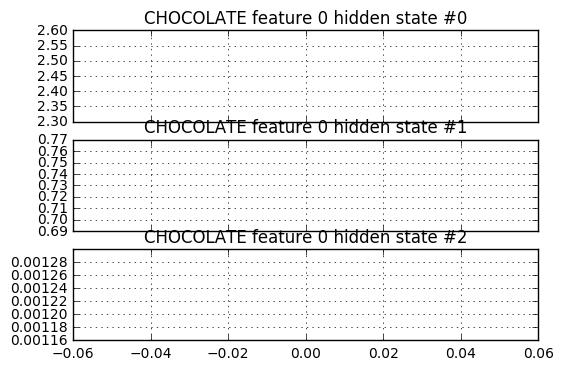

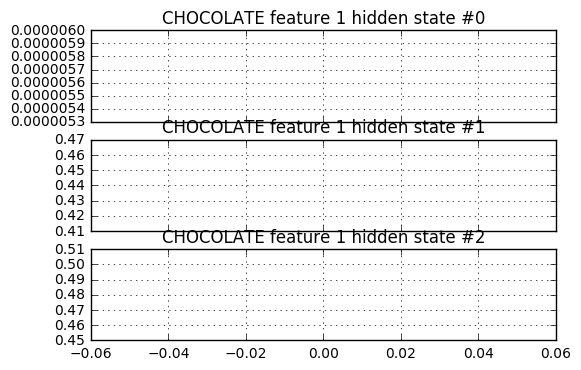

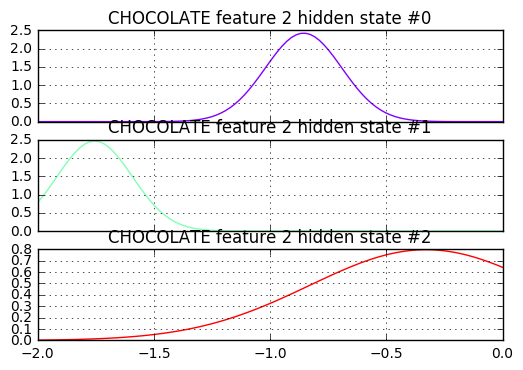

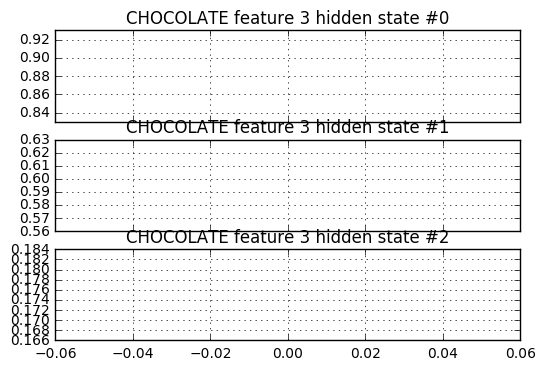

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
print(word_sequences)
print(type(split_method.split(word_sequences)))
print(split_method.split(word_sequences))
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

[[[-26, 52, 22, 134], [-26, 52, 22, 134], [-25, 46, 22, 134], [-25, 46, 22, 134], [-22, 42, 22, 134], [-24, 39, 20, 131], [-23, 40, 21, 132], [-21, 39, 21, 131], [-20, 38, 22, 130], [-21, 38, 21, 130], [-22, 37, 20, 129], [-20, 36, 22, 128], [-21, 37, 21, 129]], [[-22, 44, 26, 133], [-18, 40, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133]], [[-20, 48, 26, 183], [-21, 46, 26, 183], [-20, 43, 30, 183], [-20, 43, 30, 183], [-18, 42, 32, 182], [-18, 38, 32, 178], [-15, 35, 35, 175], [-16, 36, 35, 175], [-14, 41, 35, 175], [-13, 38, 36, 172], [-13, 41, 36, 172], [-11, 39, 38, 170], [-16, 36, 38, 170]], [[-20, 36, -14, 126], [-22, 35, -14, 126], [-22, 35, -14, 126], [-21, 31, -14, 126], [-18, 30, -14, 126], [-15, 30, -14, 126], [-13, 30, -14, 126], [-13, 30, -14, 126], [-16, 28, -14, 126], [-16, 31, -14, 126], [-15, 33, -14, 126], [-15, 35, -14, 126], [-15, 35, -14, 126], [-16, 33, -14, 126]

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV



training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    #print(word)
    #sequences_1 = sequences[word]
    #X_1, lengths_1 = Xlengths[word]
    #print(sequences_1,lengths_1)
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.010547370774200992 seconds
Training complete for BOOK with 2 states with time 4.045379865197492 seconds
Training complete for VEGETABLE with 3 states with time 1.573632083862159 seconds
Training complete for FUTURE with 2 states with time 3.704559440021538 seconds
Training complete for JOHN with 14 states with time 41.205010444309835 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.23164253297949955 seconds
Training complete for BOOK with 8 states with time 1.2651724933656396 seconds
Training complete for VEGETABLE with 9 states with time 0.4440667546440551 seconds
Training complete for FUTURE with 9 states with time 1.3773145143455992 seconds
Training complete for JOHN with 14 states with time 12.300739034075612 seconds


In [27]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.5389471198223248 seconds
Training complete for BOOK with 15 states with time 2.4997382913157082 seconds
Training complete for VEGETABLE with 15 states with time 1.683744735779399 seconds
Training complete for FUTURE with 15 states with time 2.6062462140879177 seconds
Training complete for JOHN with 15 states with time 13.394794911734166 seconds


In [28]:
# TODO: Implement Selector_customDIC in module my_model_selectors.py
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import Selector_customDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = Selector_customDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14,verbose=False).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.5528942997384689 seconds
Training complete for BOOK with 2 states with time 2.5329416416676196 seconds
Training complete for VEGETABLE with 2 states with time 1.715221590035 seconds
Training complete for FUTURE with 2 states with time 2.6543786777431677 seconds
Training complete for JOHN with 5 states with time 13.492142129148874 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
These model selectors concentrate on different aspects of the model.  In SelectorCV, we train the model on one set of data and we are measuring the performance on unseen data. Therefore selectorCV measures how generalizable the model is, and prevents overfit. The disadvantage is that we don't have ability to split data in some of the models, because we don't have enough examples. In this respect the other two model selectors are more advantageous because we can train them on all data. 
The purpose of selectorBIC is to select the simplest model with the least amount of parameters without comprimising the performance. Therefore performance and complexity are two terms in BIC equation that work against each other. However in situations where more complex models are needed complexity term may actually be too penalizing.
Finally selectorDIC focuses on the ability to classify the different states from each other. In the formula, we substract the average likelihood of the model for the other words from the likelihood for the current word. Therefore selectorBIC is a task oriented model selector. However, the biggest disadvantage I see is that we look at the average likelihood of the other models. selectorBIC may actually select a model that is not very good in differentiating between too very close models but on average gets a higher score because of the contribution by other word.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [29]:
import my_model_selectors
reload(my_model_selectors)
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 42.249s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [30]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [31]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))
print(test_set.get_item_sequences(0),test_set.get_item_Xlengths(0))
print(len(test_set.get_all_sequences()),len(test_set.get_all_Xlengths()))
print(test_set._load_sentence_word_indices())

Number of test set items: 178
Number of test set sentences: 40
[[[1, 58, -12, 122], [-6, 53, -12, 122], [-9, 45, -12, 122], [-13, 38, -12, 122], [-14, 34, -12, 122], [-13, 29, -12, 122], [-18, 25, -12, 122], [-20, 25, -12, 122], [-22, 22, -12, 122], [-18, 18, -11, 120], [-20, 22, -8, 117], [-19, 18, -9, 117], [-15, 22, -5, 100], [-12, 26, 0, 93]]] (array([[  1,  58, -12, 122],
       [ -6,  53, -12, 122],
       [ -9,  45, -12, 122],
       [-13,  38, -12, 122],
       [-14,  34, -12, 122],
       [-13,  29, -12, 122],
       [-18,  25, -12, 122],
       [-20,  25, -12, 122],
       [-22,  22, -12, 122],
       [-18,  18, -11, 120],
       [-20,  22,  -8, 117],
       [-19,  18,  -9, 117],
       [-15,  22,  -5, 100],
       [-12,  26,   0,  93]], dtype=int64), [14])
178 178
{100: [102, 103, 104, 105], 2: [0, 1, 2], 67: [63, 64, 65, 66, 67], 7: [3, 4, 5, 6], 201: [172, 173, 174, 175, 176, 177], 74: [72, 73, 74, 75], 119: [120, 121, 122, 123, 124], 12: [7, 8, 9, 10], 77: [76, 77, 78], 1

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [32]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [38]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer

%load_ext autoreload
%autoreload 2

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = Selector_customDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
failed for word_id 0 and word: FIND
failed for word_id 0 and word: SAY-1P
failed for word_id 1 and word: FIND
failed for word_id 1 and word: SAY-1P
failed for word_id 2 and word: FIND
failed for word_id 2 and word: SAY-1P
failed for word_id 3 and word: FIND
failed for word_id 3 and word: SAY-1P
failed for word_id 4 and word: FIND
failed for word_id 4 and word: SAY-1P
failed for word_id 5 and word: FIND
failed for word_id 5 and word: SAY-1P
failed for word_id 6 and word: FIND
failed for word_id 6 and word: SAY-1P
failed for word_id 7 and word: FIND
failed for word_id 7 and word: SAY-1P
failed for word_id 8 and word: FIND
failed for word_id 8 and word: SAY-1P
failed for word_id 9 and word: FIND
failed for word_id 9 and word: SAY-1P
failed for word_id 10 and word: FIND
failed for word_id 10 and word: SAY-1P
failed for word_id 11 and word: FIND
failed for word_id 11 and word: SAY-1P
failed for word_id 1

In [96]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
failed for word_id 0 and word: SAY-1P
failed for word_id 0 and word: FIND
failed for word_id 1 and word: SAY-1P
failed for word_id 1 and word: FIND
failed for word_id 2 and word: SAY-1P
failed for word_id 2 and word: FIND
failed for word_id 3 and word: SAY-1P
failed for word_id 3 and word: FIND
failed for word_id 4 and word: SAY-1P
failed for word_id 4 and word: FIND
failed for word_id 5 and word: SAY-1P
failed for word_id 5 and word: FIND
failed for word_id 6 and word: SAY-1P
failed for word_id 6 and word: FIND
failed for word_id 7 and word: SAY-1P
failed for word_id 7 and word: FIND
failed for word_id 8 and word: SAY-1P
failed for word_id 8 and word: FIND
failed for word_id 9 and word: SAY-1P
failed for word_id 9 and word: FIND
failed for word_id 10 and word: SAY-1P
failed for word_id 10 and word: FIND
failed for word_id 11 and word: SAY-1P
failed for word_id 11 and word: FIND
failed for word_id 1

In [97]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core

failed for word_id 0 and word: ANN
failed for word_id 0 and word: OLD
failed for word_id 0 and word: SAY-1P
failed for word_id 0 and word: FIND
failed for word_id 0 and word: CANDY
failed for word_id 0 and word: LEG
failed for word_id 1 and word: ANN
failed for word_id 1 and word: OLD
failed for word_id 1 and word: SAY-1P
failed for word_id 1 and word: FIND
failed for word_id 1 and word: CANDY
failed for word_id 1 and word: LEG
failed for word_id 2 and word: ANN
failed for word_id 2 and word: OLD
failed for word_id 2 and word: SAY-1P
failed for word_id 2 and word: FIND
failed for word_id 2 and word: CANDY
failed for word_id 2 and word: LEG
failed for word_id 3 and word: ANN
failed for word_id 3 and word: OLD
failed for word_id 3 and word: SAY-1P
failed for word_id 3 and word: FIND
failed for word_id 3 and word: CANDY
failed for word_id 3 and word: LEG
failed for word_id 4 and word: ANN
failed for word_id 4 and word: OLD
failed for word_id 4 and word: SAY-1P
failed for word_id 4 and wor

In [98]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = Selector_customDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
failed for word_id 0 and word: SAY-1P
failed for word_id 0 and word: FIND
failed for word_id 1 and word: SAY-1P
failed for word_id 1 and word: FIND
failed for word_id 2 and word: SAY-1P
failed for word_id 2 and word: FIND
failed for word_id 3 and word: SAY-1P
failed for word_id 3 and word: FIND
failed for word_id 4 and word: SAY-1P
failed for word_id 4 and word: FIND
failed for word_id 5 and word: SAY-1P
failed for word_id 5 and word: FIND
failed for word_id 6 and word: SAY-1P
failed for word_id 6 and word: FIND
failed for word_id 7 and word: SAY-1P
failed for word_id 7 and word: FIND
failed for word_id 8 and word: SAY-1P
failed for word_id 8 and word: FIND
failed for word_id 9 and word: SAY-1P
failed for word_id 9 and word: FIND
failed for word_id 10 and word: SAY-1P
failed for word_id 10 and word: FIND
failed for word_id 11 and word: SAY-1P
failed for word_id 11 and word: FIND
failed for word_id 1

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** Aveages of 12 combinations of features and model selectors are shown below in a table. The best features were ground and polar, because they had the lowest average score with all three model selectors. Both delta and and norm were not very good. Apparently there is not much to be gained from normalization, this might be due to similar arm sizes and heights of ASL speakers in the videos. Delta was not very good also, probably because how the arm moved relative to nose were more important than movement with respect to initial position. The most surprising result for me was that Polar_norm was also worse than polar, apparently we do loose a lot of information in polar when we are normalizing.
Overall, model selectors had also very close performance levels. Probably some model selectors do work better than others in some words, but when we train so many words, average result tends to be very similar. I have also tried to optimize selector_DIC by average the likelihood of 3 highest words instead of all word but this did not really help.
Overall we need to take into account the language structure in order to better predict the word. For example some word may be more common than other therefore we need to bias our recognition toward those words.




In [99]:
from tabulate import tabulate
results_data = [["WER table         ","selectorBIC","selectorDIC","selectorCV",'averages'],['features_ground',0.56,0.58,0.54,0.56],
['features_norm',0.62,0.62,0.61,0.616667],
['features_polar',0.55,0.54,0.58,0.556667],
['features_delta', 0.59,0.64,0.60,0.61],
['features_custom',0.59,0.59,0.62,0.6],
['averages',0.582,0.594,0.59]]
print(tabulate(results_data))

---------------  -----------  -----------  ----------  --------
WER table        selectorBIC  selectorDIC  selectorCV  averages
features_ground  0.56         0.58         0.54        0.56
features_norm    0.62         0.62         0.61        0.616667
features_polar   0.55         0.54         0.58        0.556667
features_delta   0.59         0.64         0.6         0.61
features_custom  0.59         0.59         0.62        0.6
averages         0.582        0.594        0.59
---------------  -----------  -----------  ----------  --------


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [100]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
failed for word_id 0 and word: OLD
failed for word_id 0 and word: FIND
failed for word_id 0 and word: CANDY
failed for word_id 0 and word: LEG
failed for word_id 0 and word: BORROW
failed for word_id 1 and word: OLD
failed for word_id 1 and word: FIND
failed for word_id 1 and word: CANDY
failed for word_id 1 and word: LEG
failed for word_id 1 and word: BORROW
failed for word_id 2 and word: OLD
failed for word_id 2 and word: FIND
failed for word_id 2 and word: CANDY
failed for word_id 2 and word: LEG
failed for word_id 2 and word: BORROW
failed for word_id 3 and word: OLD
failed for word_id 3 and word: FIND
failed for word_id 3 and word: CANDY
failed for word_id 3 and word: LEG
failed for word_id 3 and word: BORROW
failed for word_id 4 and word: OLD
failed for word_id 4 and word: FIND
failed for word_id 4 and word: CANDY
failed for word_id 4 and word: LEG
failed for word_id 4 and word: BORROW
failed 

.

failed for word_id 173 and word: FIND
failed for word_id 173 and word: CANDY
failed for word_id 173 and word: LEG
failed for word_id 173 and word: BORROW
failed for word_id 174 and word: OLD
failed for word_id 174 and word: FIND
failed for word_id 174 and word: CANDY
failed for word_id 174 and word: LEG
failed for word_id 174 and word: BORROW
failed for word_id 175 and word: OLD
failed for word_id 175 and word: FIND
failed for word_id 175 and word: CANDY
failed for word_id 175 and word: LEG
failed for word_id 175 and word: BORROW
failed for word_id 176 and word: OLD
failed for word_id 176 and word: FIND
failed for word_id 176 and word: CANDY
failed for word_id 176 and word: LEG
failed for word_id 176 and word: BORROW
failed for word_id 177 and word: OLD
failed for word_id 177 and word: FIND
failed for word_id 177 and word: CANDY
failed for word_id 177 and word: LEG
failed for word_id 177 and word: BORROW
failed for word_id 0 and word: OLD
failed for word_id 0 and word: FIND
failed for 

.

failed for word_id 177 and word: FIND
failed for word_id 177 and word: CANDY
failed for word_id 177 and word: LEG
failed for word_id 177 and word: BORROW



----------------------------------------------------------------------
Ran 2 tests in 21.578s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [101]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2564.662695,-1.753202e+05,-3717.960192,-330.513568,-2196.314864,-382.325969,-2873.528478,-1041.209577,-4494.410087,-658.116291,...,-1868.385715,-210.031173,-2.809296e+05,-278.983071,-211.611880,-1266.658595,-681.591929,-754.633694,-3.448737e+05,-301.376322
1,-6791.690644,-1.628911e+06,-9899.007748,-118.958118,-2502.512033,-441.624171,-7970.543151,-113.149819,-4198.828746,-553.379536,...,-183.880329,-548.100050,-4.358747e+04,-341.874211,-111.098536,-4747.124223,-1363.837198,-1494.193684,-2.184680e+05,-596.329517
2,-9576.855303,-2.520507e+06,-16163.432731,-318.573229,-4670.313658,-914.958672,-11676.616479,-887.829275,-3877.682380,-1212.108472,...,-971.265547,-793.640362,-4.129515e+05,-760.664399,-483.978522,-7242.007128,-2196.752097,-1869.519352,-1.741097e+05,-1428.551017
3,-1061.709747,-2.940894e+06,-1814.923873,-279.642514,-526.346339,-255.377577,-567.224467,-1171.290246,-33897.899104,-711.342484,...,-5100.570599,-548.542614,-1.143249e+06,-742.223768,-565.158810,-11861.278942,-288.420173,-618.250716,-2.441728e+06,-521.070155
4,-1462.548501,-6.623752e+05,-3113.233817,-99.786725,-1037.497743,-57.323454,-638.972883,-164.498017,-846.567498,-49.611306,...,-956.054397,-64.713586,-4.823743e+05,-50.739092,-208.252232,-5502.558401,-458.991554,-812.568059,-3.652996e+05,-486.300055


In [103]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
from my_recognizer import recognize_ngram

%load_ext autoreload
%autoreload 2

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize_ngram(models, test_set)
show_errors(guesses, test_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
failed for word_id 102 and word: SAY-1P
failed for word_id 102 and word: FIND
failed for word_id 103 and word: SAY-1P
failed for word_id 103 and word: FIND
failed for word_id 104 and word: SAY-1P
failed for word_id 104 and word: FIND
failed for word_id 105 and word: SAY-1P
failed for word_id 105 and word: FIND
no language for sor sentence: {} GIVE1 BUY GIVE1 ARRIVE
no language for sor sentence: {} GIVE1 BUY GIVE1 GIVE1
no language for sor sentence: {} GIVE1 BUY GIVE1 BREAK-DOWN
no language for sor sentence: {} GIVE1 BUY GIVE1 BOOK
no language for sor sentence: {} GIVE1 BUY GIVE1 BLAME
no language for sor sentence: {} GIVE1 BUY GIVE1 STUDENT
no language for sor sentence: {} GIVE1 BUY CAN ARRIVE
no language for sor sentence: {} GIVE1 BUY CAN GIVE1
no language for sor sentence: {} GIVE1 BUY CAN BREAK-DOWN
no language for sor sentence: {} GIVE1 BUY CAN BOOK
no language for sor sentence: {} GIVE1 BUY CAN

By incorporating the 3-gram language model, my error rate went from 55% down to 39%.